Pokémon is a Japanese media franchise consisting of video games, animated series and films, a trading card game, and other related media.
The franchise takes place in a shared universe in which humans co-exist with creatures known as Pokémon, a large variety of species endowed with special powers.
The franchise target audience is children aged 5 to 12, but it is known to attract people of all ages.

As 90's child, I am surely a fan of Pokémon. So today let's work on a Pokémon dataset. Have fun!

First of all, my resource for data is: https://www.kaggle.com/datasets/jaidalmotra/pokemon-dataset

I am planning to understand the data, visiualize it and try to perform a clustering algorithm.

First things first. Let's import some necessary libraries

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder  # for categorical data, we need to encode them for using clustering
from sklearn.cluster import KMeans  # i will use K-Means Clustering

Let's write some code blocks for understanding the data. We need to check shape and properties, also understand type of values.

In [3]:
def check_df(dataframe):
    print("Shape of Pokemon DataSet")
    print(dataframe.shape)
    print("\n Columns of Pokemon DataSet")
    print(dataframe.columns)
    print("\nInfo of Pokemon DataSet")
    dataframe.info()
    print("\nTypes of Pokemon DataSet")
    print(dataframe.dtypes)
    print("\n Head of Pokemon DataSet")
    print(dataframe.head())
    print("\n Tail of Pokemon DataSet")
    print(dataframe.tail())
    print("\nNull Data of Pokemon DataSet: ")
    print(dataframe.isnull().sum())


In [4]:
def column_detection(dataframe: pd.DataFrame, cat_th: int = 10, car_th: int = 20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                       dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                    dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print("\nCategoric Data : ")
    print(cat_cols)
    print("\nNumeric Data : ")
    print(num_cols)
    print("\nCategoric But Cardinal Data : ")
    print(cat_but_car)
    print("\nNumeric But Categoric Data : ")
    print(num_but_cat)
    print("\nColumns Overview :")
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

And I define some functions for plotting.

In [13]:
def cat_summary(dataframe, col_name, plot=True):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        # Convert boolean Series to categorical
        dataframe[col_name] = dataframe[col_name].astype(str)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation=45)  # Adjust the rotation angle as needed
        plt.show(block=True)


In [14]:
def hist_num_columns_show(dataframe, num_column):
    dataframe[num_column].hist(bins=20)
    plt.xlabel(num_column)
    plt.ylabel("Frequency")
    plt.show(block=True)

Some functions for outlier check...

In [19]:
def outlier_thresholds(dataframe: pd.DataFrame, col_name: str, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [20]:
def check_outlier(dataframe: pd.DataFrame, col_name: str):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(
            axis=None):
        return True
    else:
        return False

The second thing is reading the data, my data is in csv format.

In [5]:
df = pd.read_csv('/content/Pokemon.csv')

In [6]:
check_df(df)

Shape of Pokemon DataSet
(1072, 13)

 Columns of Pokemon DataSet
Index(['number', 'name', 'type1', 'type2', 'total', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'generation', 'legendary'],
      dtype='object')

Info of Pokemon DataSet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      1072 non-null   int64 
 1   name        1072 non-null   object
 2   type1       1072 non-null   object
 3   type2       574 non-null    object
 4   total       1072 non-null   int64 
 5   hp          1072 non-null   int64 
 6   attack      1072 non-null   int64 
 7   defense     1072 non-null   int64 
 8   sp_attack   1072 non-null   int64 
 9   sp_defense  1072 non-null   int64 
 10  speed       1072 non-null   int64 
 11  generation  1072 non-null   int64 
 12  legendary   1072 non-null   bool  
dtypes: bool(1), int64(9), obje

In [7]:
df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [8]:
df.describe()

,number,total,hp,attack,defense,sp_attack,sp_defense,speed,generation
count,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000
mean,445.219216,440.885261,70.486940,80.938433,74.968284,73.273321,72.476679,68.792910,4.294776
std,267.772806,121.379077,26.868039,32.463582,31.208059,32.643119,27.934253,30.076281,2.346472
min,1.000000,175.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000
25%,209.750000,330.000000,50.000000,56.000000,52.000000,50.000000,50.000000,45.000000,2.000000
50%,442.500000,460.500000,68.000000,80.000000,70.000000,65.000000,70.000000,65.000000,4.000000
75%,681.250000,519.250000,84.000000,100.000000,90.000000,95.000000,90.000000,90.000000,6.000000
max,898.000000,1125.000000,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000,8.000000


In [9]:
cat_cols, num_cols, cat_but_car, num_but_cat = column_detection(df)


Categoric Data : 
['type1', 'type2', 'generation', 'legendary']

Numeric Data : 
['number', 'total', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

Categoric But Cardinal Data : 
['name']

Numeric But Categoric Data : 
['generation', 'legendary']

Columns Overview :
Observations: 1072
Variables: 13
cat_cols: 4
num_cols: 8
cat_but_car: 1
num_but_cat: 2


My data includes these attributes:

**Number**: The ID for each pokemon

**Name**: The name of each pokemon

**Type 1**: Each pokemon has a type, this determines weakness/resistance to attacks

**Type 2**: Some pokemon are dual type and have 2

**Total**: Sum of all stats that come after this, a general guide to how strong a pokemon is

**HP**: Hit points, or health, defines how much damage a pokemon can withstand before fainting

**Attack**: The base modifier for normal attacks (eg. Scratch, Punch)

**Defense**: The base damage resistance against normal attacks

**SP Atk**: Special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)

**SP Def**: Special defense, the base damage resistance against special attacks

**Speed**: Determines which pokemon attacks first each round

**Generation**: The generation of games where the pokemon was first introduced

**Legendary**: Some pokemon are much rarer than others, and are dubbed "legendary"

As you can see, there is null values in type2.Let's fill them and check data again.

In [10]:
df['type2'] = df['type2'].fillna(df['type1'])
check_df(df)

Shape of Pokemon DataSet
(1072, 13)

 Columns of Pokemon DataSet
Index(['number', 'name', 'type1', 'type2', 'total', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'generation', 'legendary'],
      dtype='object')

Info of Pokemon DataSet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      1072 non-null   int64 
 1   name        1072 non-null   object
 2   type1       1072 non-null   object
 3   type2       1072 non-null   object
 4   total       1072 non-null   int64 
 5   hp          1072 non-null   int64 
 6   attack      1072 non-null   int64 
 7   defense     1072 non-null   int64 
 8   sp_attack   1072 non-null   int64 
 9   sp_defense  1072 non-null   int64 
 10  speed       1072 non-null   int64 
 11  generation  1072 non-null   int64 
 12  legendary   1072 non-null   bool  
dtypes: bool(1), int64(9), obje

Now i need to encode my categorical values because i will perform clustering algorithm.

In [11]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder
df['type1_encoded'] = label_encoder.fit_transform(df['type1'])
df['type2_encoded'] = label_encoder.fit_transform(df['type2'])
df['legendary_encoded'] = label_encoder.fit_transform(df['legendary'])

Let's try to plot.

           type1      Ratio
type1                      
Water        136  12.686567
Normal       117  10.914179
Grass         94   8.768657
Bug           83   7.742537
Psychic       80   7.462687
Fire          67   6.250000
Electric      63   5.876866
Rock          60   5.597015
Dark          48   4.477612
Fighting      45   4.197761
Ghost         43   4.011194
Poison        42   3.917910
Ground        42   3.917910
Dragon        41   3.824627
Steel         39   3.638060
Ice           38   3.544776
Fairy         23   2.145522
Flying         9   0.839552
Blastoise      1   0.093284
Graass         1   0.093284


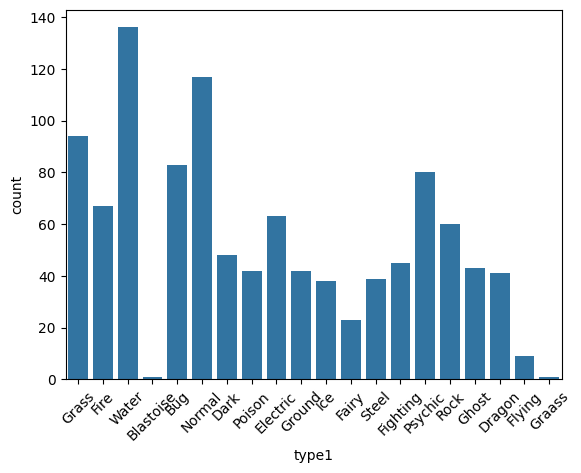

          type2      Ratio
type2                     
Flying      118  11.007463
Water        94   8.768657
Psychic      87   8.115672
Normal       84   7.835821
Grass        72   6.716418
Fairy        64   5.970149
Fighting     62   5.783582
Poison       58   5.410448
Ground       57   5.317164
Fire         52   4.850746
Steel        49   4.570896
Dragon       48   4.477612
Electric     45   4.197761
Dark         42   3.917910
Ghost        41   3.824627
Ice          38   3.544776
Rock         31   2.891791
Bug          29   2.705224
Graass        1   0.093284


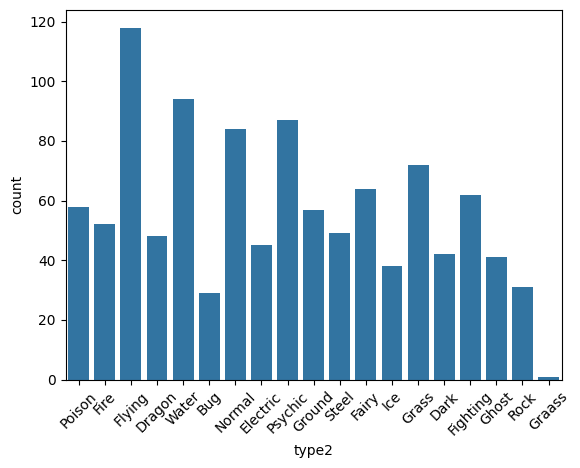

            generation      Ratio
generation                       
1                  178  16.604478
5                  166  15.485075
3                  160  14.925373
8                  139  12.966418
4                  121  11.287313
7                  114  10.634328
2                  106   9.888060
6                   85   7.929104
0                    3   0.279851


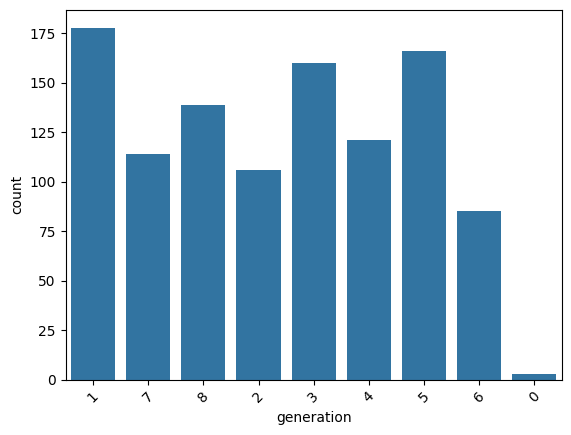

           legendary      Ratio
legendary                      
False            954  88.992537
True             118  11.007463


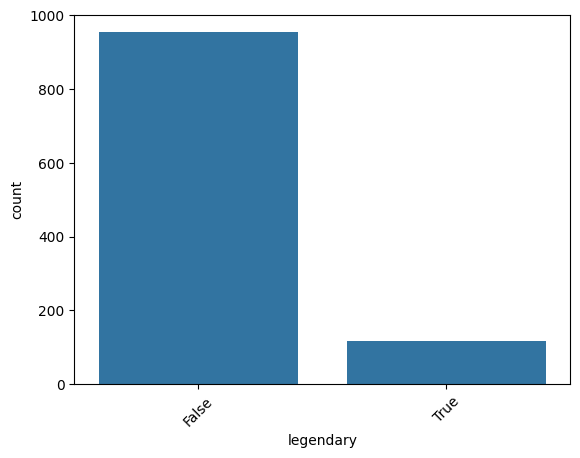

In [15]:
for col in cat_cols:
    cat_summary(df, col)

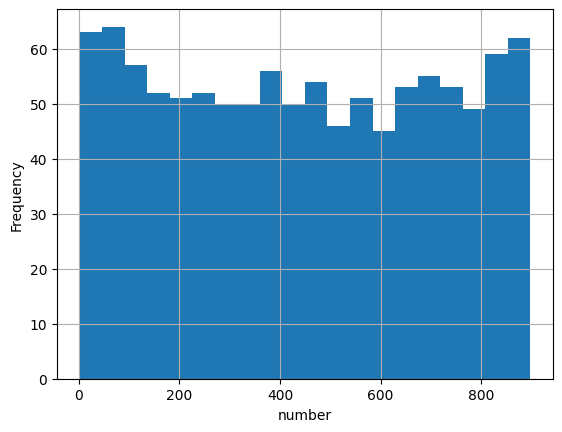

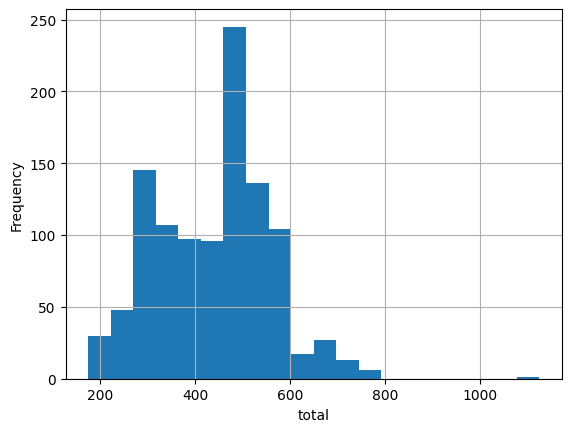

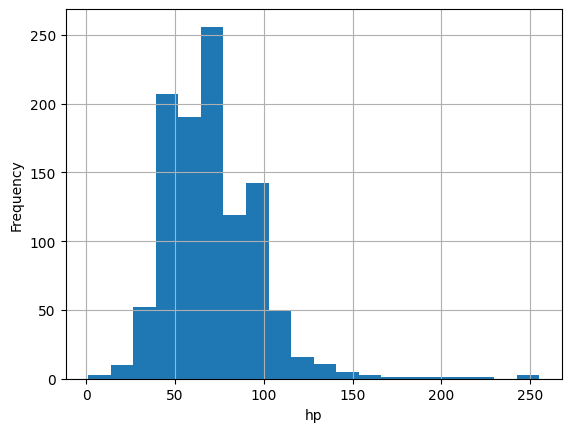

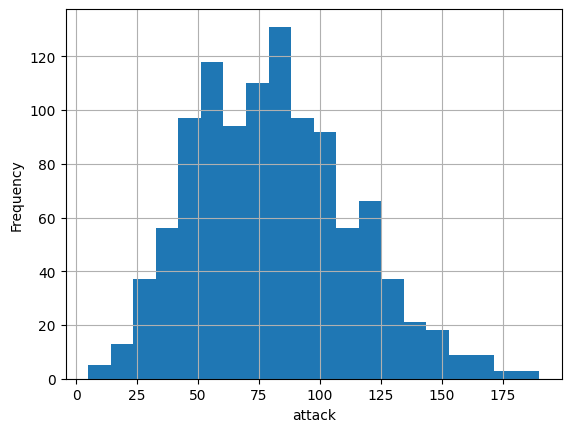

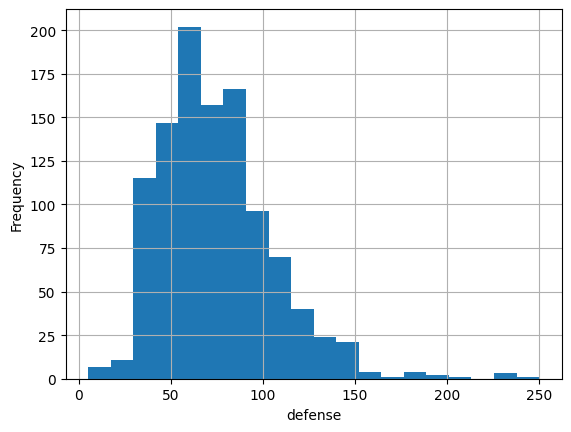

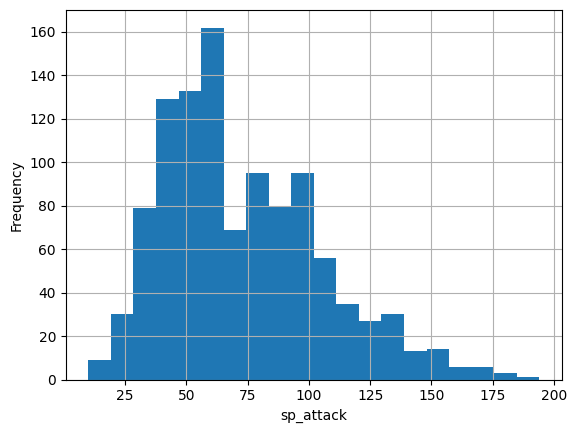

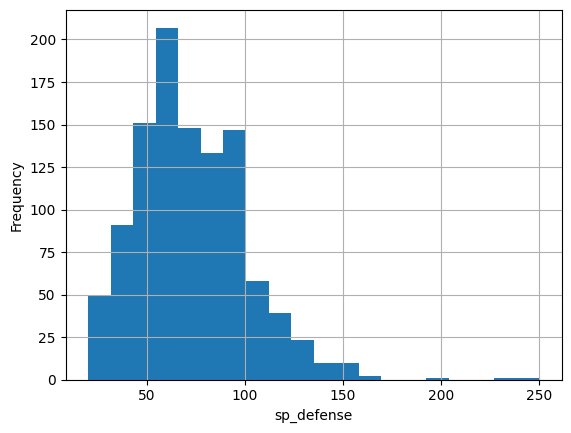

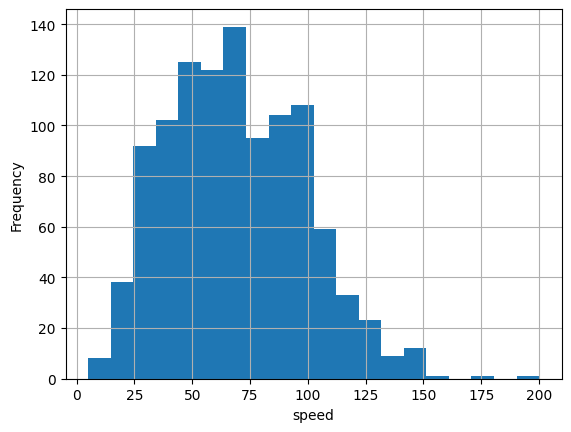

In [16]:
for num_col in num_cols:
    hist_num_columns_show(df, num_col)


More plots :)

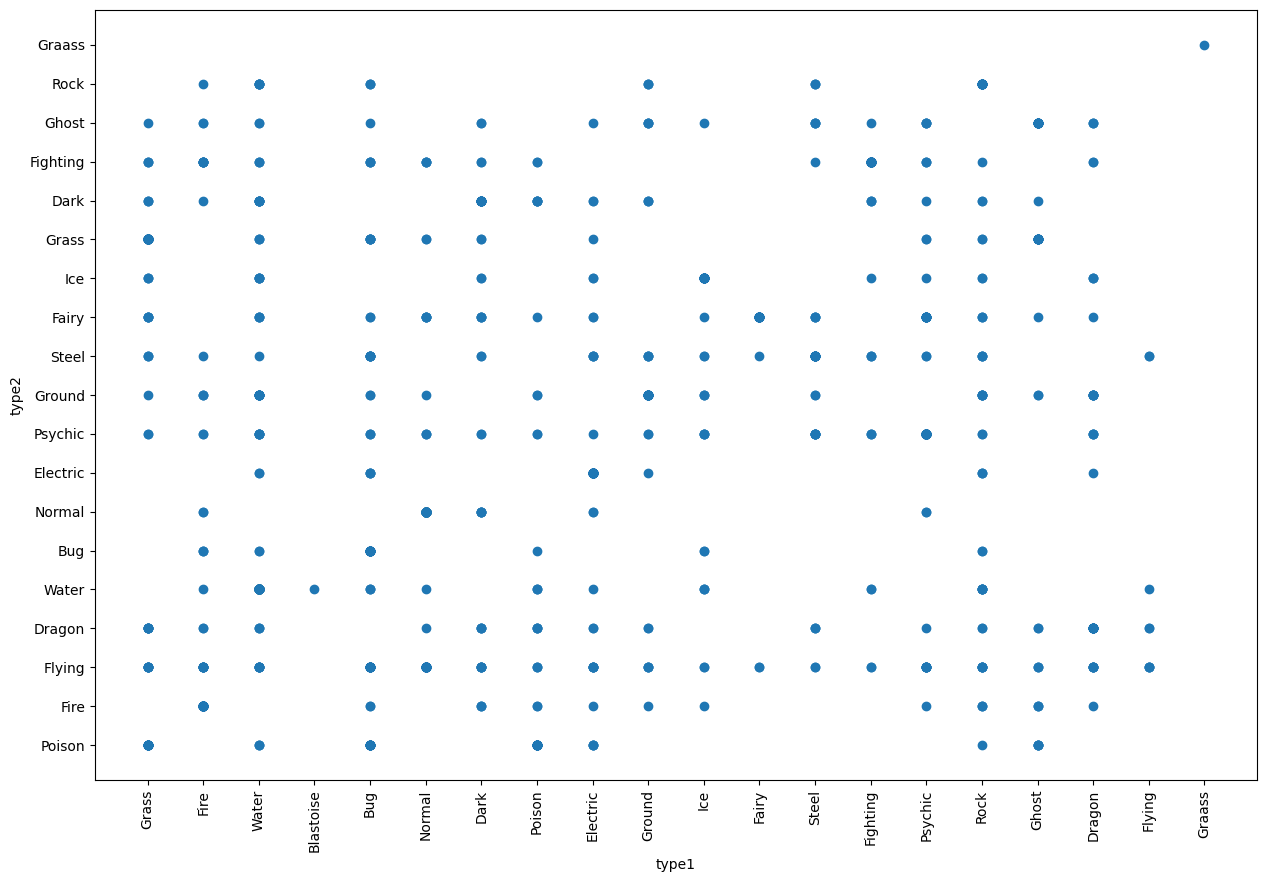

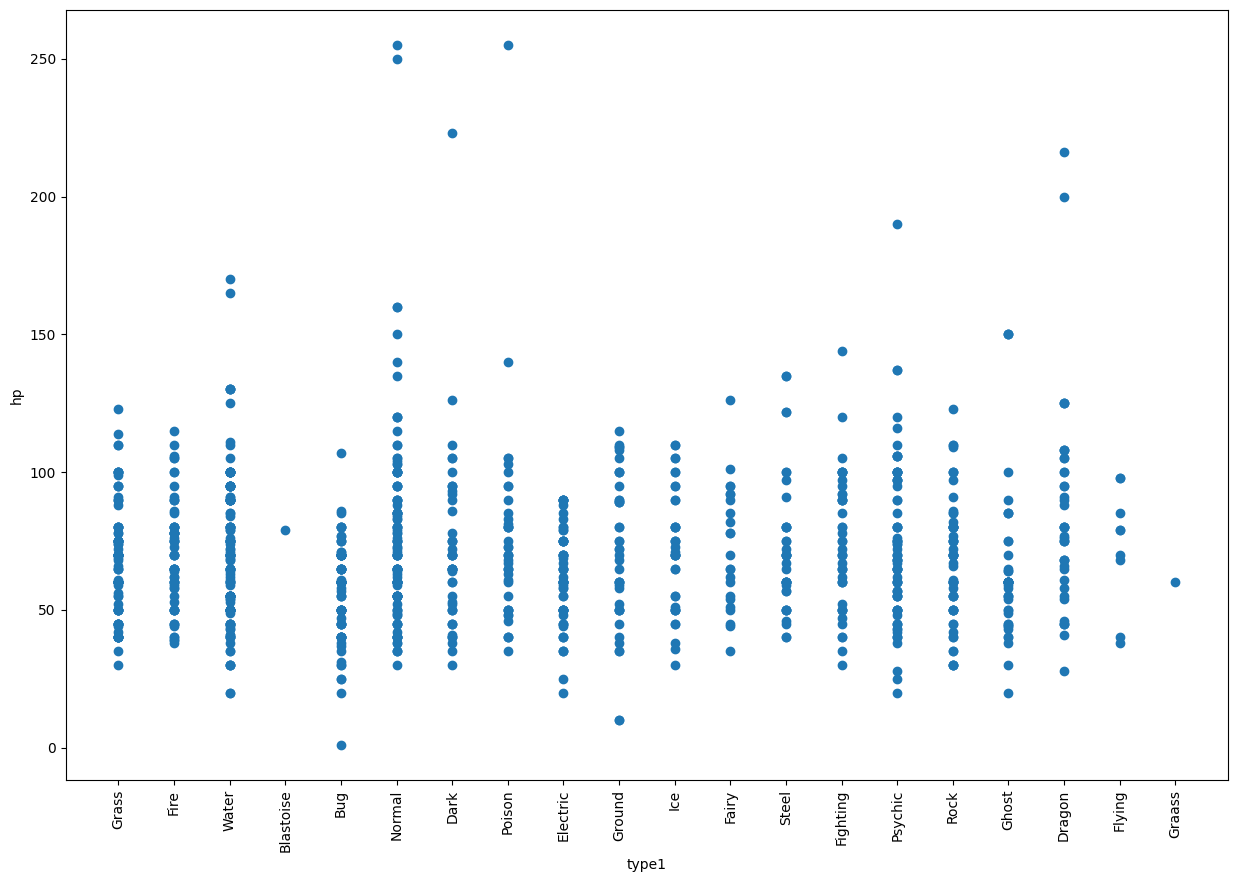

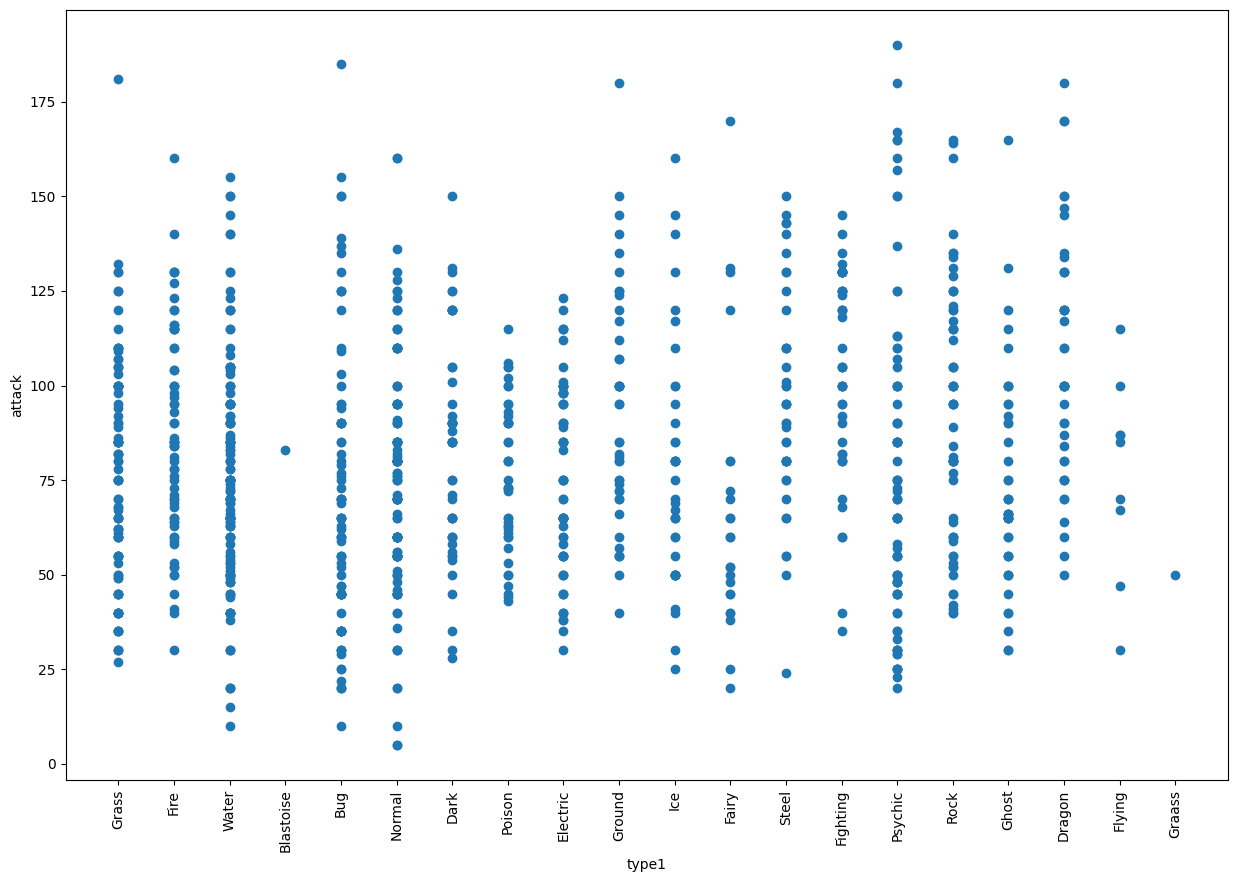

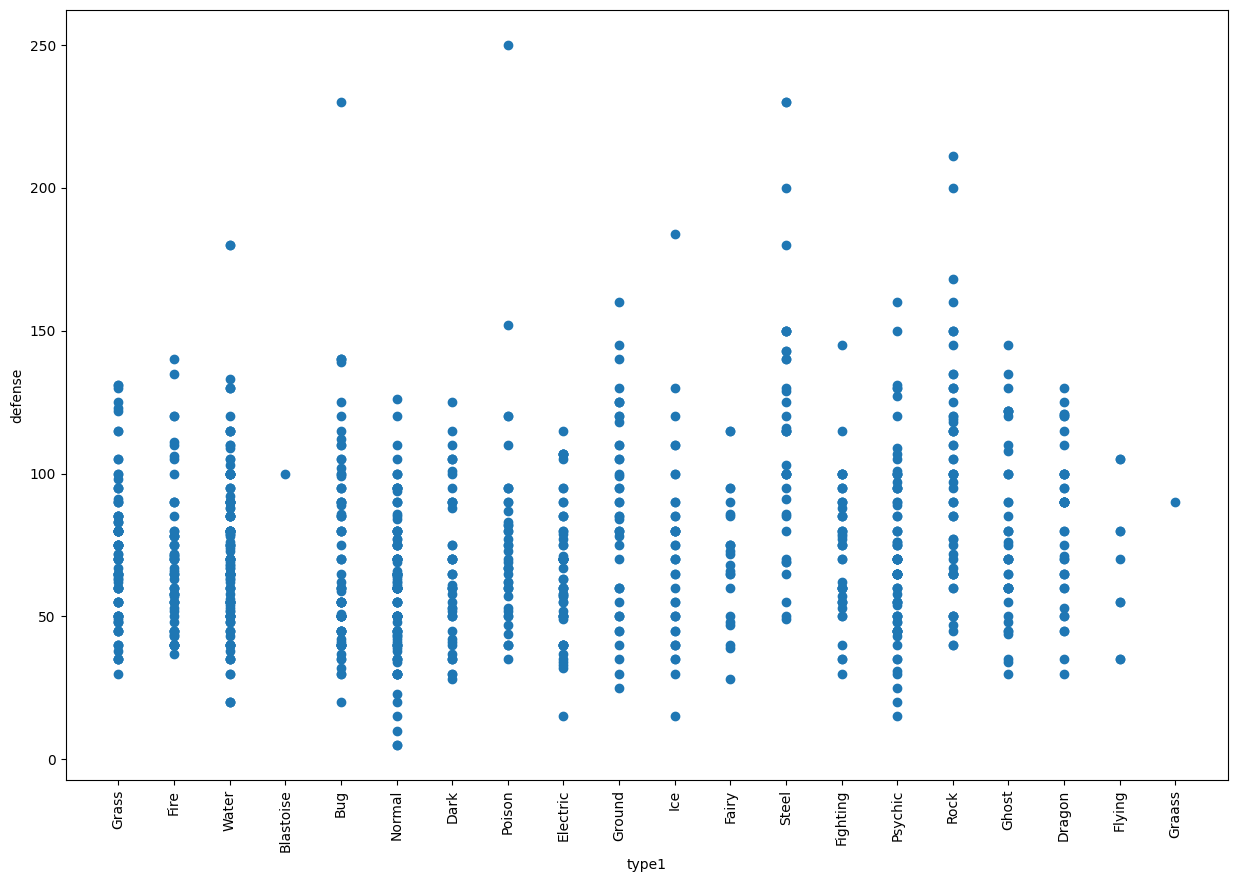

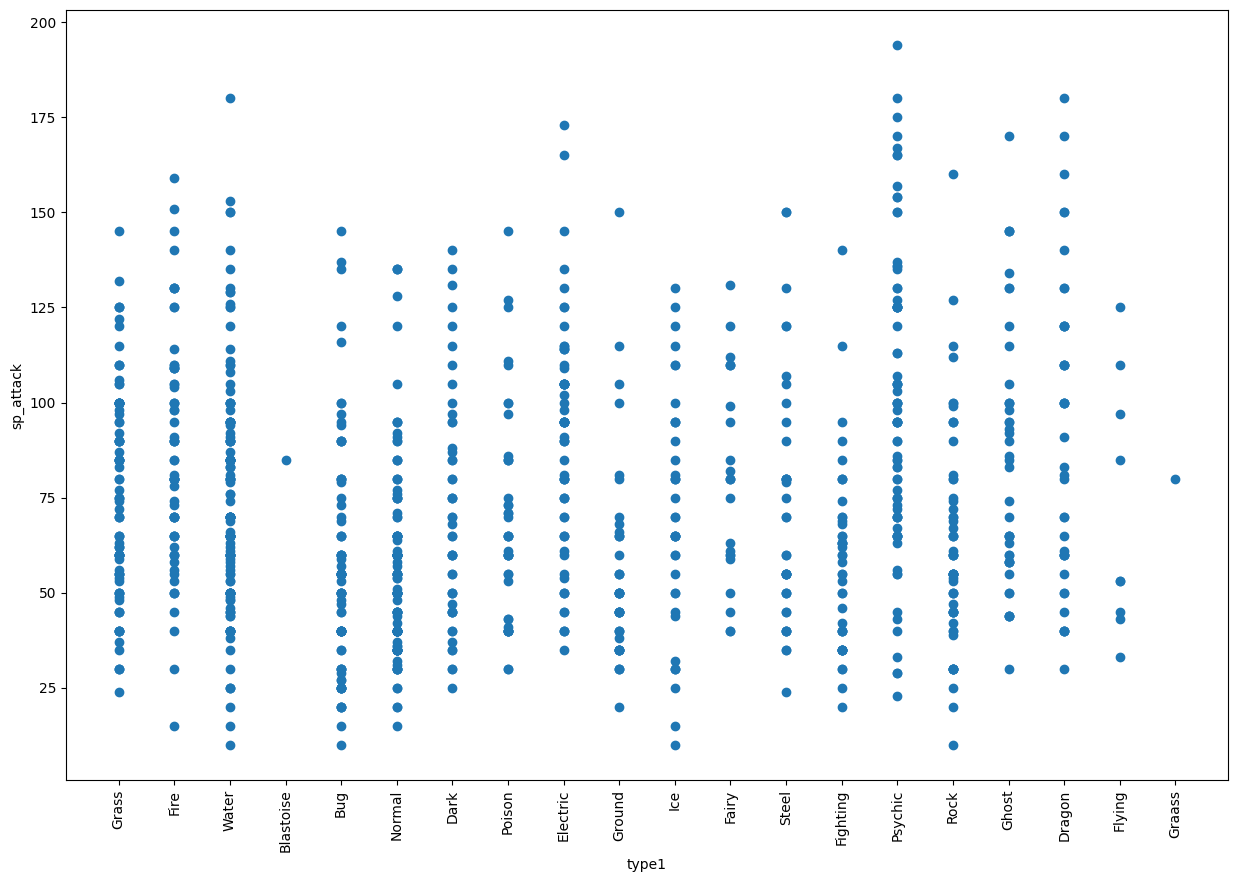

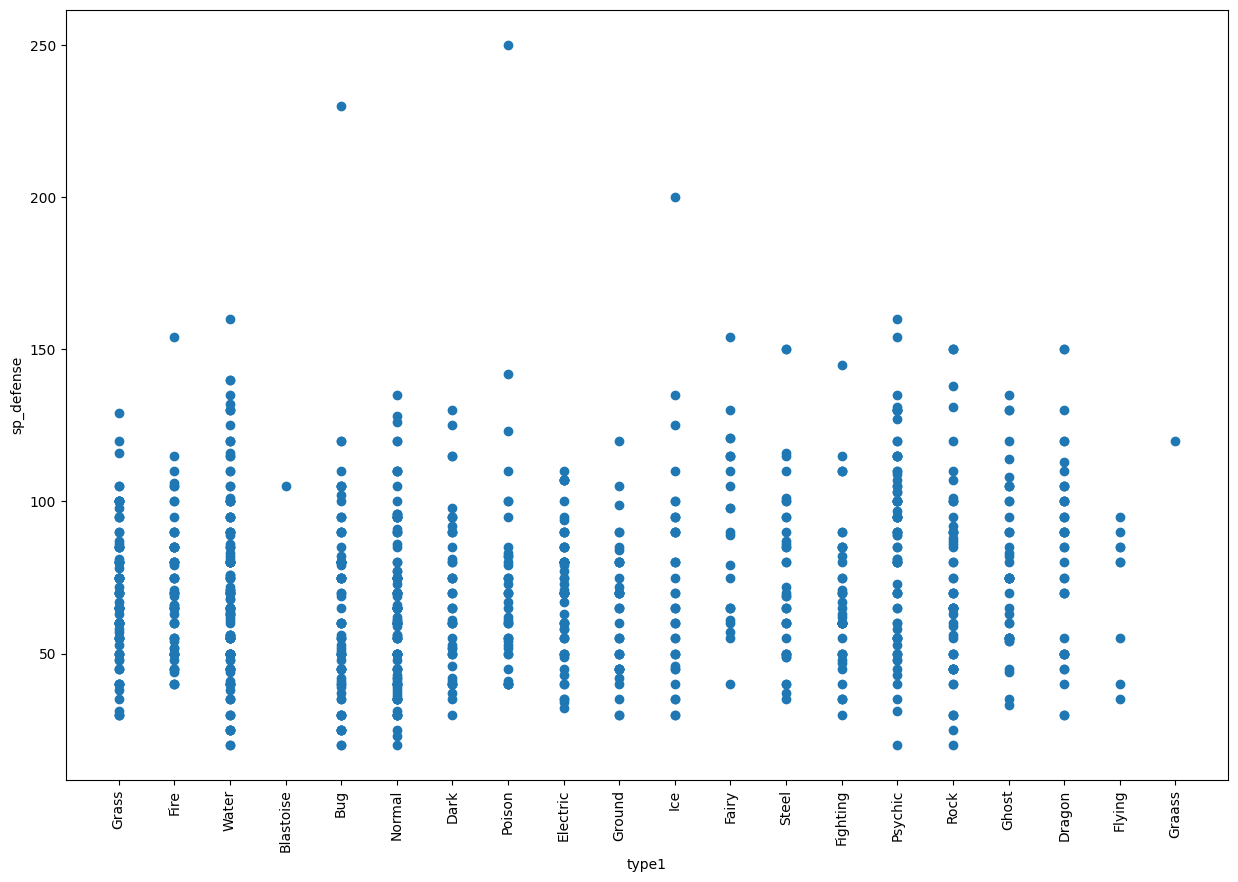

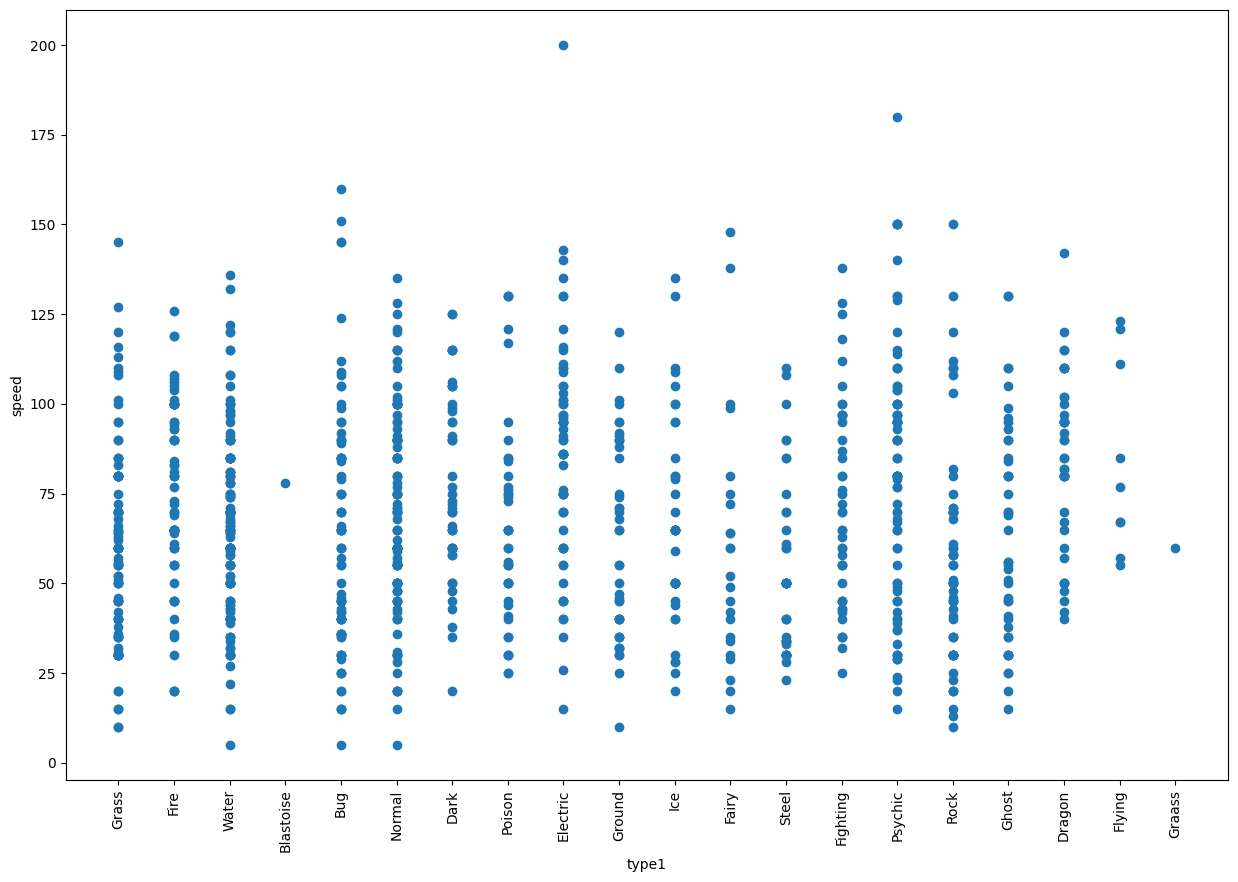

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118],
 [Text(0, 0, '10'),
  Text(1, 0, '15'),
  Text(2, 0, '20'),
  Text(3, 0, '23'),
  Text(4, 0, '24'),
  Text(5, 0, '25'),
  Text(6, 0, '27'),
  Text(7, 0, '29'),
  Text(8, 0, '30'),
  Text(9, 0, '31'),
  Text(10, 0, '32'),
  Text(11, 0, '33'),
  Text(12, 0, '35'),
  Text(13, 0,

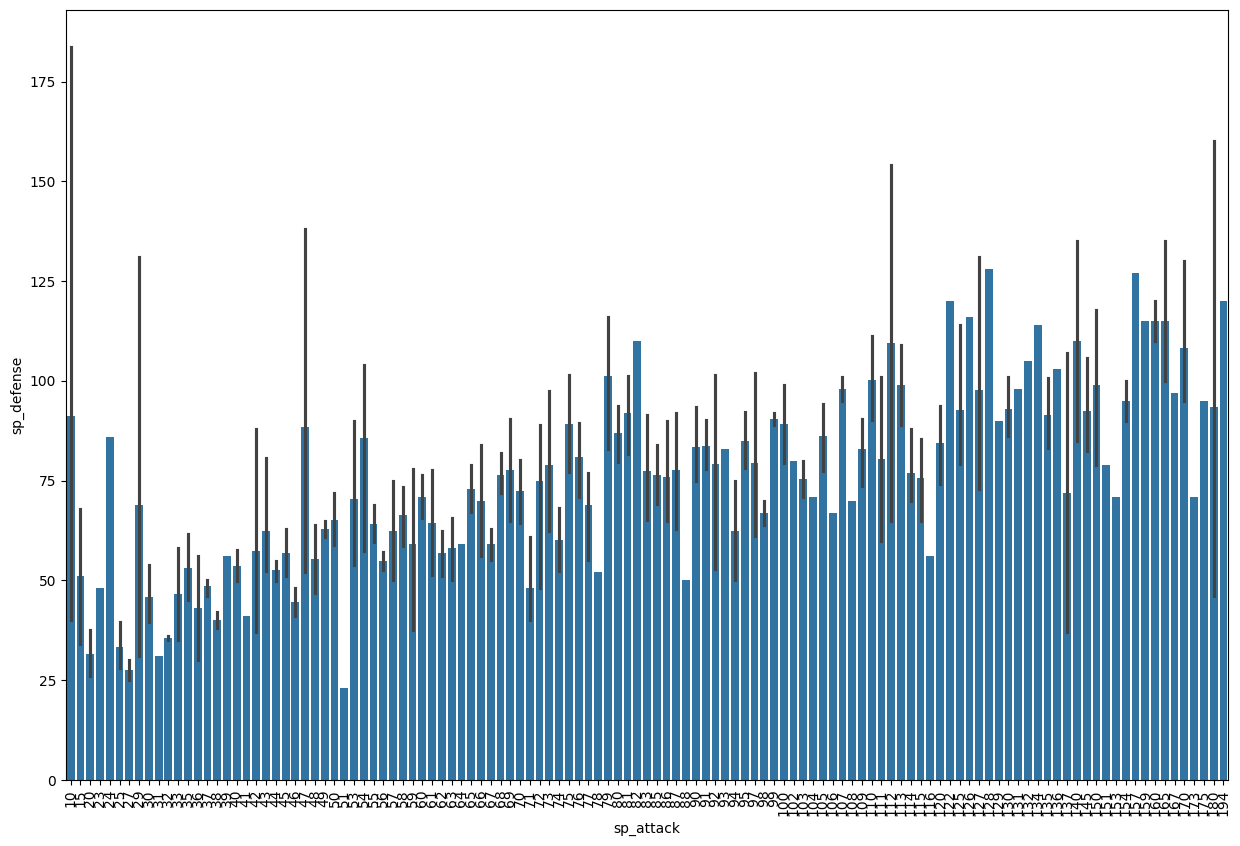

In [17]:
plt.figure(figsize=(15,10))
plt.scatter('type1',"type2" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('type2')
plt.show()

plt.figure(figsize=(15,10))
plt.scatter('type1',"hp" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('hp')
plt.show()


plt.figure(figsize=(15,10))
plt.scatter('type1',"attack" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('attack')
plt.show()


plt.figure(figsize=(15,10))
plt.scatter('type1',"defense" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('defense')
plt.show()


plt.figure(figsize=(15,10))
plt.scatter('type1',"sp_attack" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('sp_attack')
plt.show()

plt.figure(figsize=(15,10))
plt.scatter('type1',"sp_defense" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('sp_defense')
plt.show()

plt.figure(figsize=(15,10))
plt.scatter('type1',"speed" , data=df)
plt.xticks(rotation=90)
plt.xlabel('type1')
plt.ylabel('speed')
plt.show()

plt.figure(figsize=(15,10))
ax = sns.barplot(x="sp_attack", y="sp_defense", data=df)
plt.xticks(rotation= 90)

Now try to understand correlation.

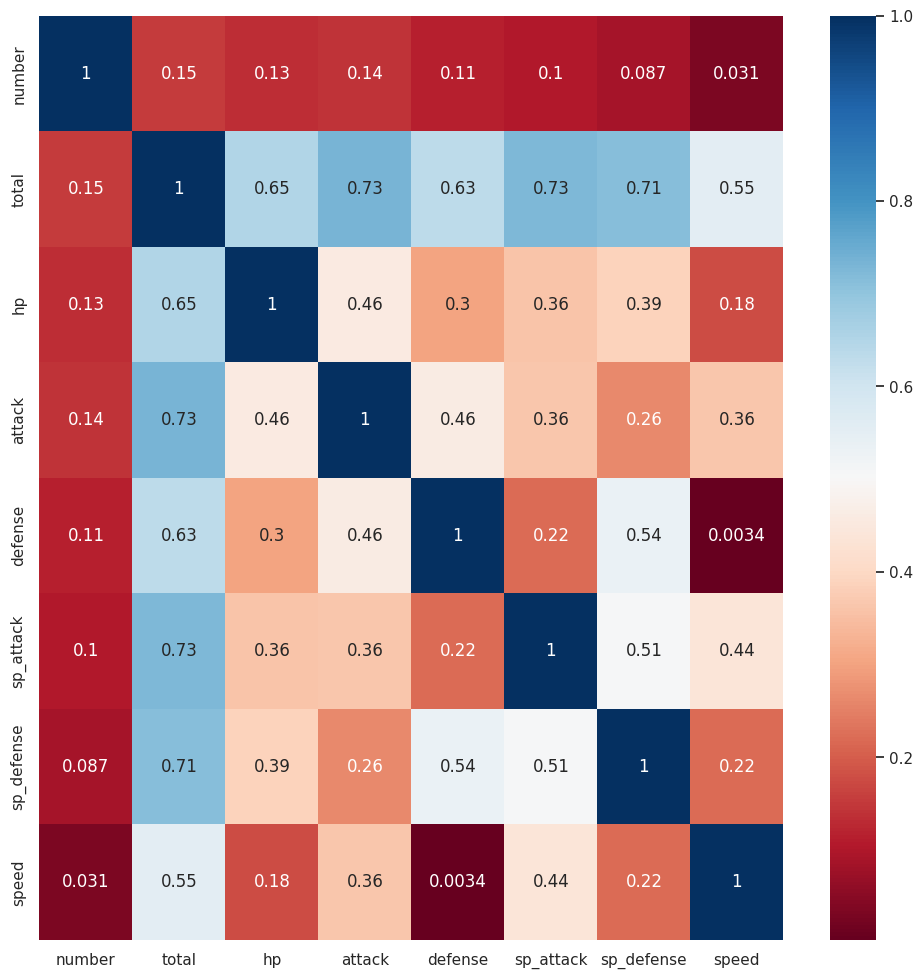

In [18]:
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

Let's check outliers


 number :
(-497.5, 1388.5) 
 total :
(46.125, 803.125) 
 hp :
(-1.0, 135.0) 
 attack :
(-10.0, 166.0) 
 defense :
(-5.0, 147.0) 
 sp_attack :
(-17.5, 162.5) 
 sp_defense :
(-10.0, 150.0) 
 speed :
(-22.5, 157.5) 
 number :
False


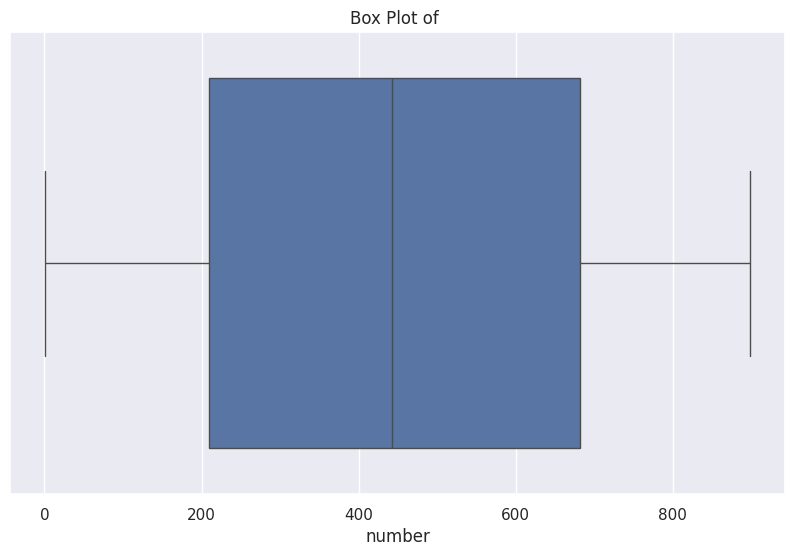


 total :
True


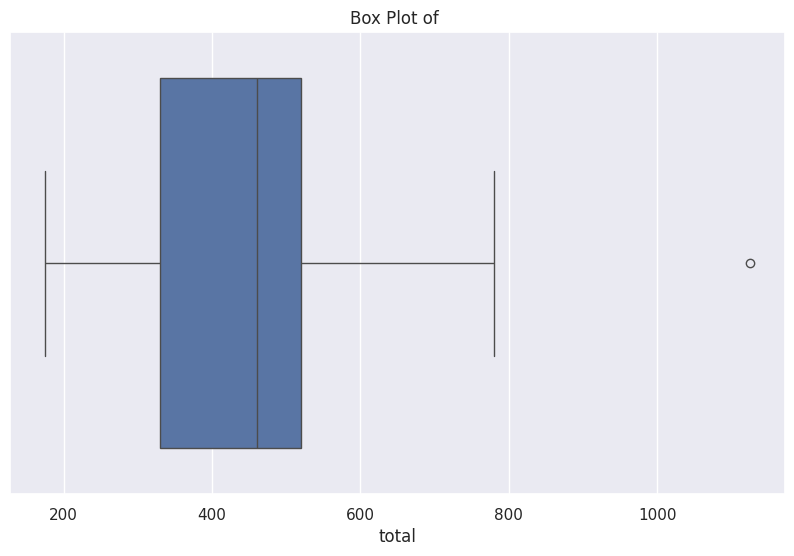


 hp :
True


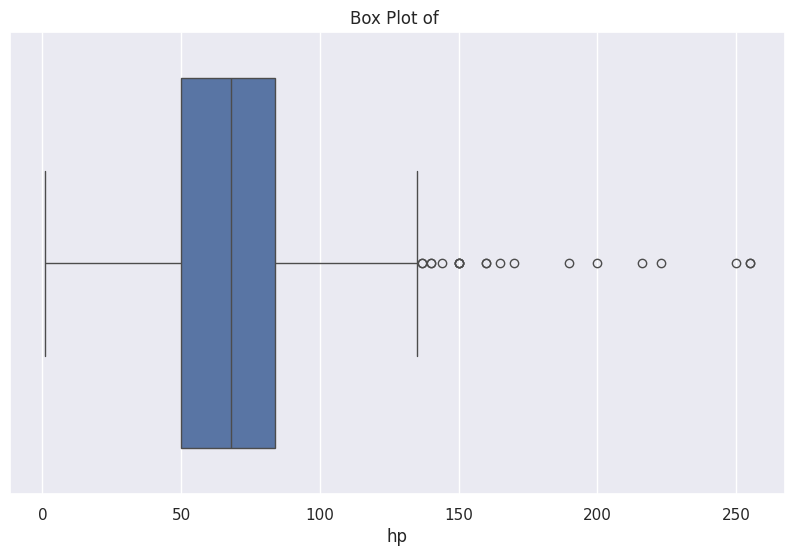


 attack :
True


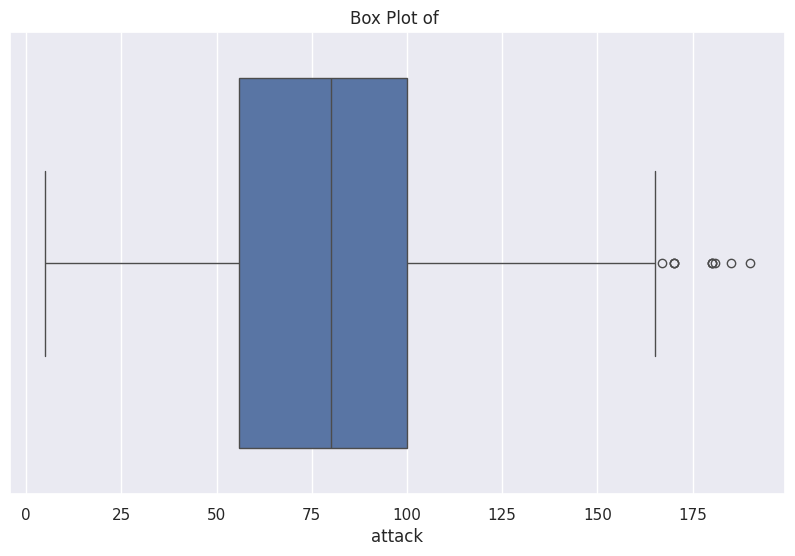


 defense :
True


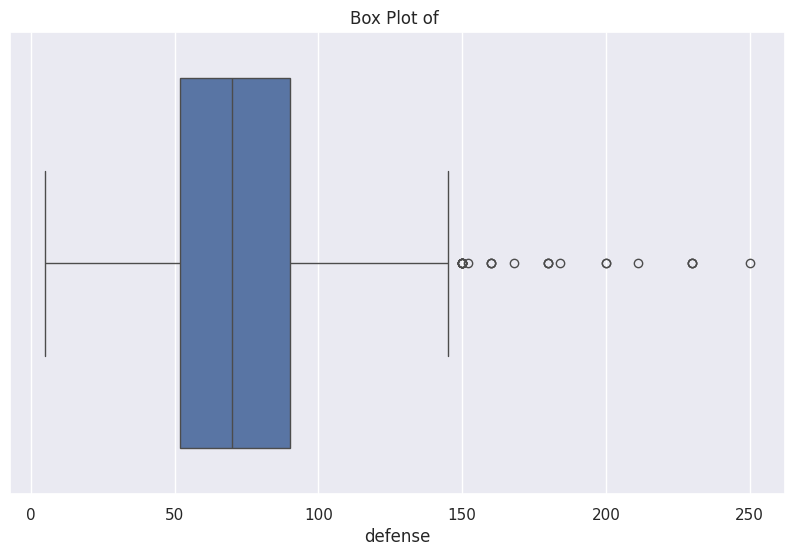


 sp_attack :
True


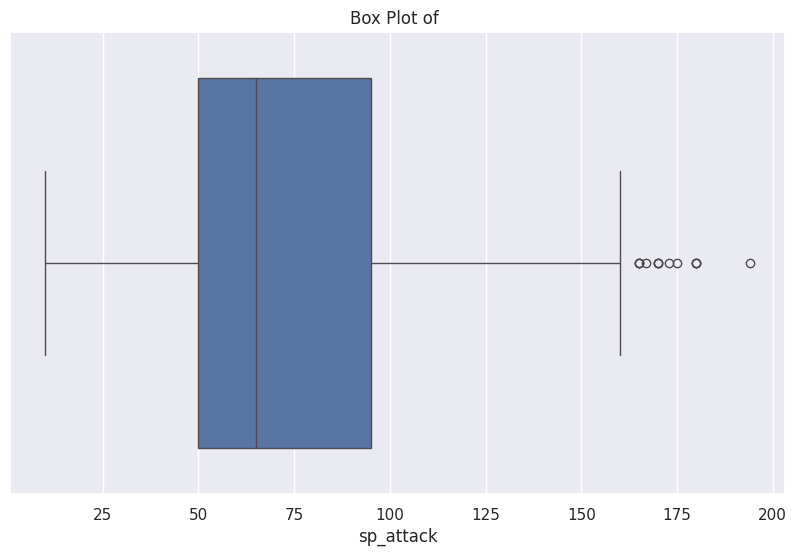


 sp_defense :
True


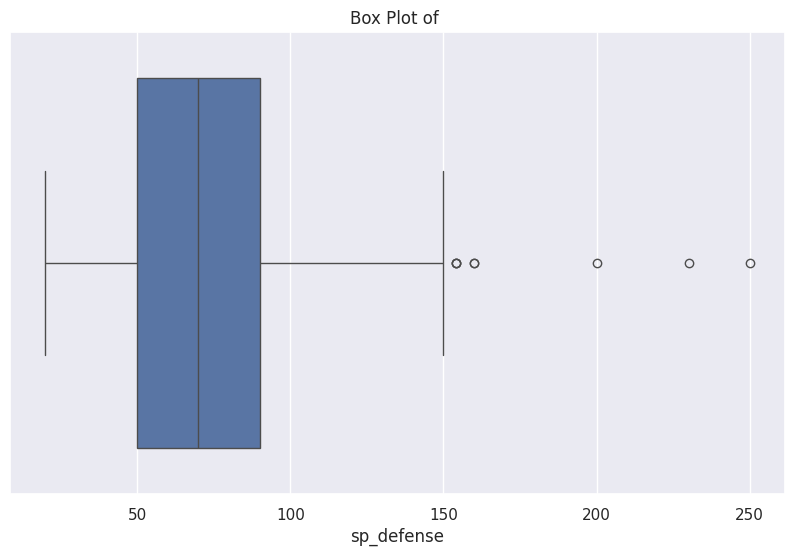


 speed :
True


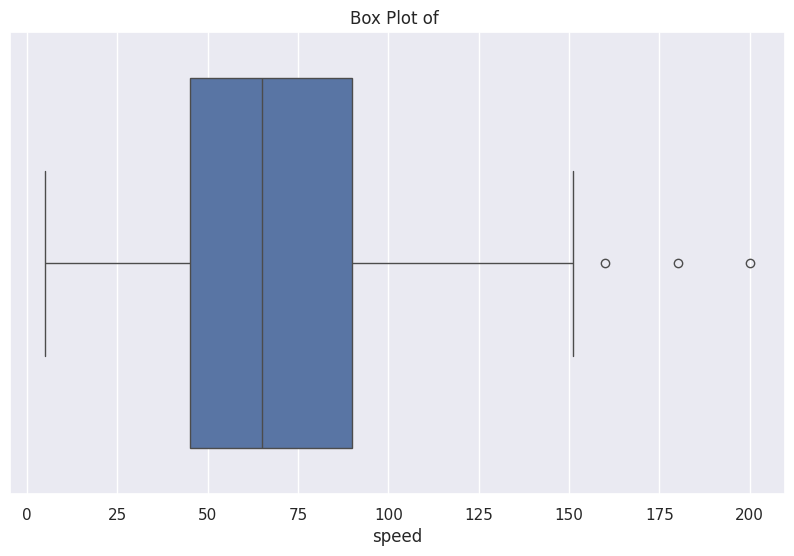

In [21]:
for num_col in num_cols:
    print('\n',num_col, ':')
    low_limit, up_limit = outlier_thresholds(df, num_col)
    print("({}, {})".format(low_limit, up_limit), end=" ")

for num_col in num_cols:
    print('\n',num_col, ':')
    print(check_outlier(df, num_col))
    # Assuming you have a pandas DataFrame named df and a column named 'column_name'
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[num_col])
    plt.title('Box Plot of ')
    plt.show()

Now, I want to perform clustering. So, first i will find suitable cluster number by using Elbow Method.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

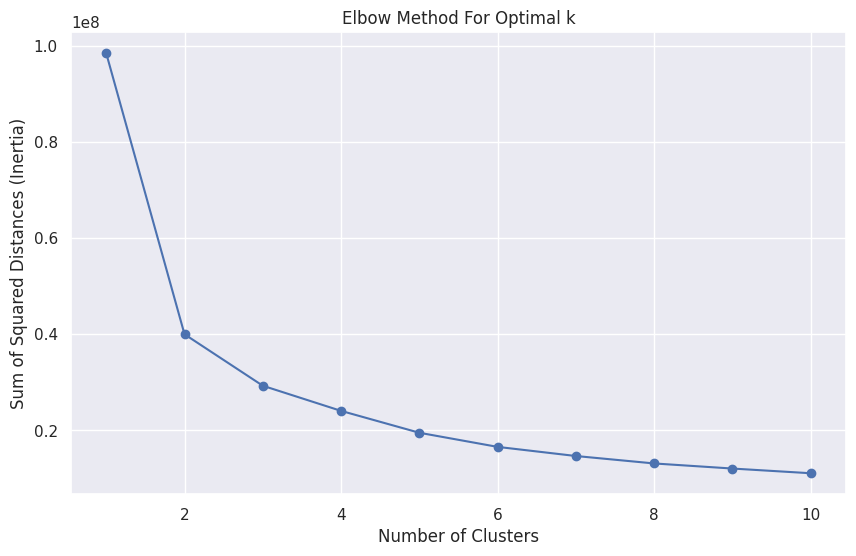

In [22]:
cluster_data = df.drop(columns=['name','type1', 'type2', 'legendary'])
# Determine the optimal number of clusters using the Elbow Method
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

Now, try to find clusters...

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


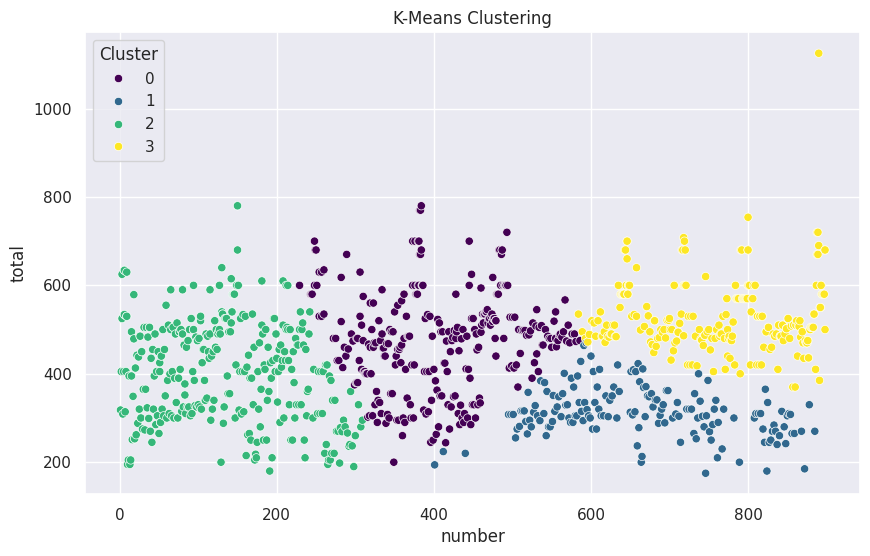

In [23]:
# Optimal number of clusters is 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(cluster_data)

# Get cluster labels
labels = kmeans.labels_
cluster_data['Cluster'] = labels

# Visualizing clusters using a scatter plot (for 2D data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cluster_data.iloc[:, 0], y=cluster_data.iloc[:, 1], hue=cluster_data['Cluster'], palette='viridis')
plt.title('K-Means Clustering')
plt.show()

Yey! We did it!

Thanks for reading!